In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Tue Feb 22 02:44:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Fine-Tuning Swin Transformers for Image Classification

In this notebook, we'll walk through how to leverage `malware datasets` and process image classification datasets, and then use them to fine-tune a pre-trained SwinT with 🤗 `transformers`.

To get started, lets first install both those packages.

In [ ]:
# blocks output in Colab 💄

! pip install datasets transformers

     |████████████████████████████████| 311 kB 7.8 MB/s 
     |████████████████████████████████| 3.5 MB 104.0 MB/s 
     |████████████████████████████████| 243 kB 69.8 MB/s 
     |████████████████████████████████| 133 kB 81.1 MB/s 
     |████████████████████████████████| 1.1 MB 88.3 MB/s 
     |████████████████████████████████| 67 kB 7.3 MB/s 
     |████████████████████████████████| 6.8 MB 80.7 MB/s 
     |████████████████████████████████| 895 kB 55.9 MB/s 
     |████████████████████████████████| 596 kB 70.5 MB/s 
     |████████████████████████████████| 144 kB 85.9 MB/s 
     |████████████████████████████████| 271 kB 92.7 MB/s 
     |████████████████████████████████| 94 kB 4.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Load a dataset

Let's start by loading a small image classification dataset and taking a look at its structure.

We'll use the `normalized-set dataset`, which is a collection of pictures of malware and benign. 👾

In [ ]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import os

imageDim = 224
dirPath = '/content/drive/MyDrive/normalized-set'
batchSize = 32

In [ ]:
def LoadDataset(_dataset):
    dsPath = os.path.join(dirPath, _dataset)
    dataGenerator = transforms.Compose([
        transforms.Resize((imageDim, imageDim)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    dataFolder = torchvision.datasets.ImageFolder(
        root = dsPath,
        transform = dataGenerator,
    )

    datasetLoader = DataLoader(
        dataFolder,
        batch_size=batchSize,
        shuffle=True,
    )

    datasetLoader.requires_grad = True

    print(_dataset + " Class [", datasetLoader.dataset.class_to_idx, "]")
    print(_dataset + " Numbers [", len(datasetLoader.dataset.imgs), "]")
    print(_dataset + " Batch Size [", datasetLoader.batch_size, "]")

    return datasetLoader

In [ ]:
trainDataset = LoadDataset('training')
validationDataset = LoadDataset('validation')
testDataset = LoadDataset('test')

training Class [ {'benign': 0, 'malware': 1} ]
training Numbers [ 24130 ]
training Batch Size [ 32 ]
validation Class [ {'benign': 0, 'malware': 1} ]
validation Numbers [ 6890 ]
validation Batch Size [ 32 ]
test Class [ {'benign': 0, 'malware': 1} ]
test Numbers [ 3442 ]
test Batch Size [ 32 ]


Let's take a look at the image 👀

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 224, 224)


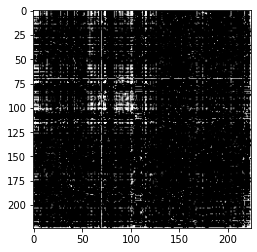

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def CustomImshow(_img):
    # img = _img.to_numpy()
    img = _img.numpy()
    print(img.shape)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

sampleData, sampleLabel = next(iter(trainDataset))
CustomImshow(sampleData[0])

## Loading SwinT Feature Extractor

Now that we know what our images look like and have a better understanding of the problem we're trying to solve, let's see how we can prepare these images for our model.

When SwinT models are trained, specific transformations are applied to images being fed into them. Use the wrong transformations on your image and the model won't be able to understand what it's seeing! 🖼 ➡️ 🔢

To make sure we apply the correct transformations, we will use a [`AutoFeatureExtractor`](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoFeatureExtractor) initialized with a configuration that was saved along with the pretrained model we plan to use. In our case, we'll be using the [microsoft/swin-tiny-patch4-window7-224](https://huggingface.co/microsoft/swin-tiny-patch4-window7-224) model, so let's load its feature extractor from the 🤗 Hub.

In [ ]:
from transformers import AutoFeatureExtractor

modelNameOrPath = 'microsoft/swin-tiny-patch4-window7-224'
featureExtractor = AutoFeatureExtractor.from_pretrained(modelNameOrPath)

If we print a feature extractor, we can see its configuration.

In [ ]:
featureExtractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "size": 224
}

## Training and Evaluation

The data is processed and we are ready to start setting up the training pipeline. We will make use of 🤗's Trainer, but that'll require us to do a few things first:
- Define a collate function
- Define an evaluation metric. During training, the model should be evaluated on its prediction accuracy. We should define a compute_metrics function accordingly.
- Load a pretrained checkpoint. We need to load a pretrained checkpoint and configure it correctly for training.
- Define the training configuration.

After having fine-tuned the model, we will correctly evaluate it on the evaluation data and verify that it has indeed learned to correctly classify our images.

## Define our data collator

Batches are coming in as lists of tensors, so we just unpack + stack those into batch tensors.

We return a batch `dict` from our `collate_fn` so we can simply `**unpack` the inputs to our model later. ✨

In [ ]:
import torch

def CollateFn(_batch):
    return {
        'pixel_values': torch.stack([x[0] for x in _batch]),
        'labels': torch.tensor([x[1] for x in _batch])
    }

## Define an evaluation metric

Here, we load the [accuracy](https://huggingface.co/metrics/accuracy) metric from `datasets`, and then write a function that takes in a model prediction + computes the accuracy.

In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def ComputeMetrics(_p):
    return metric.compute(predictions=np.argmax(_p.predictions, axis=1), references=_p.label_ids)

Downloading:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

In [ ]:
trainDataset.dataset.classes

['benign', 'malware']

Now we can load our pretrained model. We'll add `num_labels` on init to make sure the model creates a classification head with the right number of units. We'll also include the `id2label` and `label2id` mappings so we have human readable labels in the 🤗 hub widget if we choose to `push_to_hub`.

In [ ]:
from transformers import SwinForImageClassification

labels = trainDataset.dataset.classes

model = SwinForImageClassification.from_pretrained(
    modelNameOrPath,
    # num_labels=len(labels),
    # id2label={str(i): c for i, c in enumerate(labels)},
    # label2id={c: str(i) for i, c in enumerate(labels)}
)

We're almost ready to train! The last thing we'll do before that is set up the training configuration by difining [`TrainingArguments`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments).

Most of these are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually its ideal to drop unused feature columns, as it makes it easier to unpack inputs into the model's call function. But, in our case, we need the unused fatures (`image`in particular) in order to create 'pixel_values'.

What I'm trying to say is that you'll have a bad time if you forget to set `remove_unused_columns=False`.

In [ ]:
from transformers import TrainingArguments

trainingArgs = TrainingArguments(
    # output_dir="/content/drive/MyDrive/vit-base-demo-v5",
    output_dir="/content/swint",
    per_device_train_batch_size=16,
    evaluation_strategy="steps",
    num_train_epochs=4,
    fp16=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True,
)

Now, all instances can be passed to Trainer and we are ready to start training!

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=trainingArgs,
    data_collator=CollateFn,
    compute_metrics=ComputeMetrics,
    train_dataset=trainDataset.dataset,
    eval_dataset=validationDataset.dataset,
    tokenizer=featureExtractor,
)

Using amp half precision backend


In [ ]:
trainResults = trainer.train()
trainer.save_model()
trainer.log_metrics("train", trainResults.metrics)
trainer.save_metrics("train", trainResults.metrics)
trainer.save_state()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 24130
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 6036


Step,Training Loss,Validation Loss,Accuracy
100,0.794000,0.665159,0.663135
200,0.707000,0.612212,0.667925
300,0.611300,0.599118,0.674311
400,0.541700,0.603741,0.679971
500,0.574200,0.630652,0.653846
600,0.535200,0.534129,0.735269
700,0.575600,0.531962,0.717126
800,0.566500,0.504552,0.749057
900,0.462000,0.465306,0.794049
1000,0.463800,0.439280,0.816691


***** Running Evaluation *****
  Num examples = 6890
  Batch size = 8
Saving model checkpoint to /content/swint/checkpoint-100
Configuration saved in /content/swint/checkpoint-100/config.json
Model weights saved in /content/swint/checkpoint-100/pytorch_model.bin
Configuration saved in /content/swint/checkpoint-100/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 6890
  Batch size = 8
Saving model checkpoint to /content/swint/checkpoint-200
Configuration saved in /content/swint/checkpoint-200/config.json
Model weights saved in /content/swint/checkpoint-200/pytorch_model.bin
Configuration saved in /content/swint/checkpoint-200/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 6890
  Batch size = 8
Saving model checkpoint to /content/swint/checkpoint-300
Configuration saved in /content/swint/checkpoint-300/config.json
Model weights saved in /content/swint/checkpoint-300/pytorch_model.bin
Configuration saved in /content/swint/checkpoint-300/pr

***** train metrics *****
  epoch                    =          4.0
  total_flos               = 2296643906GF
  train_loss               =       0.3387
  train_runtime            =   4:46:19.58
  train_samples_per_second =        5.618
  train_steps_per_second   =        0.351


In [ ]:
metrics = trainer.evaluate(testDataset.dataset)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 3442
  Batch size = 8


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.8948
  eval_loss               =     0.2452
  eval_runtime            = 0:17:36.77
  eval_samples_per_second =      3.257
  eval_steps_per_second   =      0.408


In [ ]:
!cp -r /content/swint /content/drive/MyDrive/models